# Visualizing congestion in downtown Toronto

## Introduction

This notebook shows how to visualize speed data provided by City of Toronto's open data portal. It contains a calculation of "travel time index", a congestion indicator developed and used by transportation agencies and research institutes, including the Texas A&M Transportation Institute [1]. 

## Theory

Travel time index (TTI) is defined as the ratio of observed travel time (usually averaged over many vehicles) to the "free-flow" travel time (deterined by a historial average of overnight travel speeds) (see equation below). A trip that takes 10 minutes in free-flow conditions, but takes 20 minutes due to local conditions such as congestion, results in a TTI of 2.0. TTI can equivalently be calculated by taking the ratio of free-flow speed to observed speed (because the length in question is the same and therefore divides out of the definition).

\begin{equation}
TTI = \frac{\mathrm{observed travel time}}{\mathrm{free-flow travel time}} = \frac{\mathrm{free-flow speed}}{\mathrm{observed speed}}
\end{equation}

The free-flow speed (FFS) is considered as a constant for each segment of road, inherently determined by the geometry of the road and human nature. It should be recalculated if conditions change, but is otherwise a constant.

In this notebook, FFS will be calculated by taking the average of all speeds on a given segment between the hours of 9pm and 6am.

## Sketch

The remainder of the notebook contains working code to calculate TTI in downtown Toronto, using data from the City of Toronto's Open Data Portal [2]. Calculations are done using the Python packages `numpy` and `pandas`.

Calculating TTI is not enough, the results should be presented in an intiuitive and easy-to-understand way. This notebook also shows how to read and work with shapefiles (`.shp`) and make maps using `geopandas`, which itself is based on `matplotlib`. Other packages used include `shapely` (for geometric manipulations), and `contextily` (adding basemaps).

[1] Schrank, D., Eisele, B., and Lomax, T. 2019 Urban Mobility Report. Appendix A - Methodology. Retrieved from https://static.tti.tamu.edu/tti.tamu.edu/documents/mobility-report-2019-appx-a.pdf

[2] City of Toronto. Open Data License. Retrieved from https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-licence/

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import contextily as ctx
import pylab as P
import matplotlib.animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

In [3]:
# a helper function, based on the one provided in the Geopandas docs
def add_basemap(ax,
                zoom,
                url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png',
                # Map tiles by Stamen Design, under CC BY 3.0. Modification by the author.
                # The only modification to the tiles is the transparency, or "alpha". I like 0.5 to make the colours pop.
                alpha=0.5,
               ):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear',
              alpha=alpha)
    ax.axis((xmin, xmax, ymin, ymax))

    
# declare where the raw data is stored, and where you want output to be saved, on your machine
data_path = '/Users/jeffsalvail/documents/data/'
output_path = '/Users/jeffsalvail/Dropbox/Python/geo/toronto/king_st_2018_output/'

# and this caption should be on all the figures
attribution_string = '''Contains information licensed under the Open Government Licence – Toronto. Available at open.toronto.ca
Map tiles by Stamen Design, under CC BY 3.0. Modification by the author.'''

def add_attribution_string(fig):
    fig.suptitle(attribution_string,
                  x=0.1,y=0.05,
                  ha = 'left',
                  va = 'bottom',
                  fontsize=8,
                )

In [4]:
# original filename: 'detailed-bluetooth-travel-time-2018.csv', renamed locally to 'king_st_2018.csv'
# downloaded from
# https://open.toronto.ca/dataset/king-st-transit-pilot-detailed-bluetooth-travel-time/

df = pd.read_csv(data_path+'king_st_2018.csv',
                usecols=[0,1,5,6],
                parse_dates = [1,]).rename(columns={'result_id':'segment_id'})

df.loc[df[df['tt']==0.].index,'tt']=np.nan #some observations are tt=0, change to nan
df=df.set_index('segment_id')

print("Number of rows read:",len(df))
df[:10]

Number of rows read: 5422954


datetime_bin     tt  obs
segment_id                                 
DU_BA_CO_BA 2018-01-01 00:00:00   62.0    1
DU_BA_CO_BA 2018-01-01 00:05:00   86.0    3
DU_BA_CO_BA 2018-01-01 00:10:00   57.0    2
DU_BA_CO_BA 2018-01-01 00:25:00  123.0    3
DU_BA_CO_BA 2018-01-01 00:30:00  126.5    4
DU_BA_CO_BA 2018-01-01 00:35:00  164.5    4
DU_BA_CO_BA 2018-01-01 00:40:00   93.0    8
DU_BA_CO_BA 2018-01-01 00:45:00   96.5    2
DU_BA_CO_BA 2018-01-01 00:50:00   75.0    3
DU_BA_CO_BA 2018-01-01 00:55:00   43.0    1

In [5]:
# original filename: 'detailed-bluetooth-travel-time-2018.csv', renamed locally to 'king_st_2018.csv'
# downloaded from
# https://open.toronto.ca/dataset/king-st-transit-pilot-bluetooth-travel-time-segments/

gdf = gpd.read_file(
    data_path+'king_st_2018_shapefile/bluetooth_segments.shp'
    ).rename(columns={'segment_na':'segment_id'}).set_index('segment_id')[['length','geometry']]

print("Number of rows read:",len(gdf))
gdf[:10]

Number of rows read: 138


length                                           geometry
segment_id                                                            
DU_BA_CO_BA   510.0  LINESTRING (-79.406022366 43.652311681, -79.40...
CO_BA_CO_UN  1430.0  LINESTRING (-79.407722935 43.656481958, -79.40...
CO_PA_CO_UN  1895.0  LINESTRING (-79.367981848 43.664285907, -79.36...
CO_PA_DU_PA   586.0  LINESTRING (-79.367981848 43.664285907, -79.36...
CO_UN_CO_BA  1430.0  LINESTRING (-79.39049459899999 43.659858837, -...
FB_SP_FB_YK   988.0  (LINESTRING (-79.39300461099999 43.640562822, ...
WE_YO_WE_UN   611.0  LINESTRING (-79.377370343 43.64784629, -79.377...
FB_SP_FB_BA   683.0  LINESTRING (-79.39300461099999 43.640562822, -...
FB_SP_FR_SP   291.0  LINESTRING (-79.39300461099999 43.640562822, -...
CO_BA_DU_BA   552.0  LINESTRING (-79.407722935 43.656481958, -79.40...

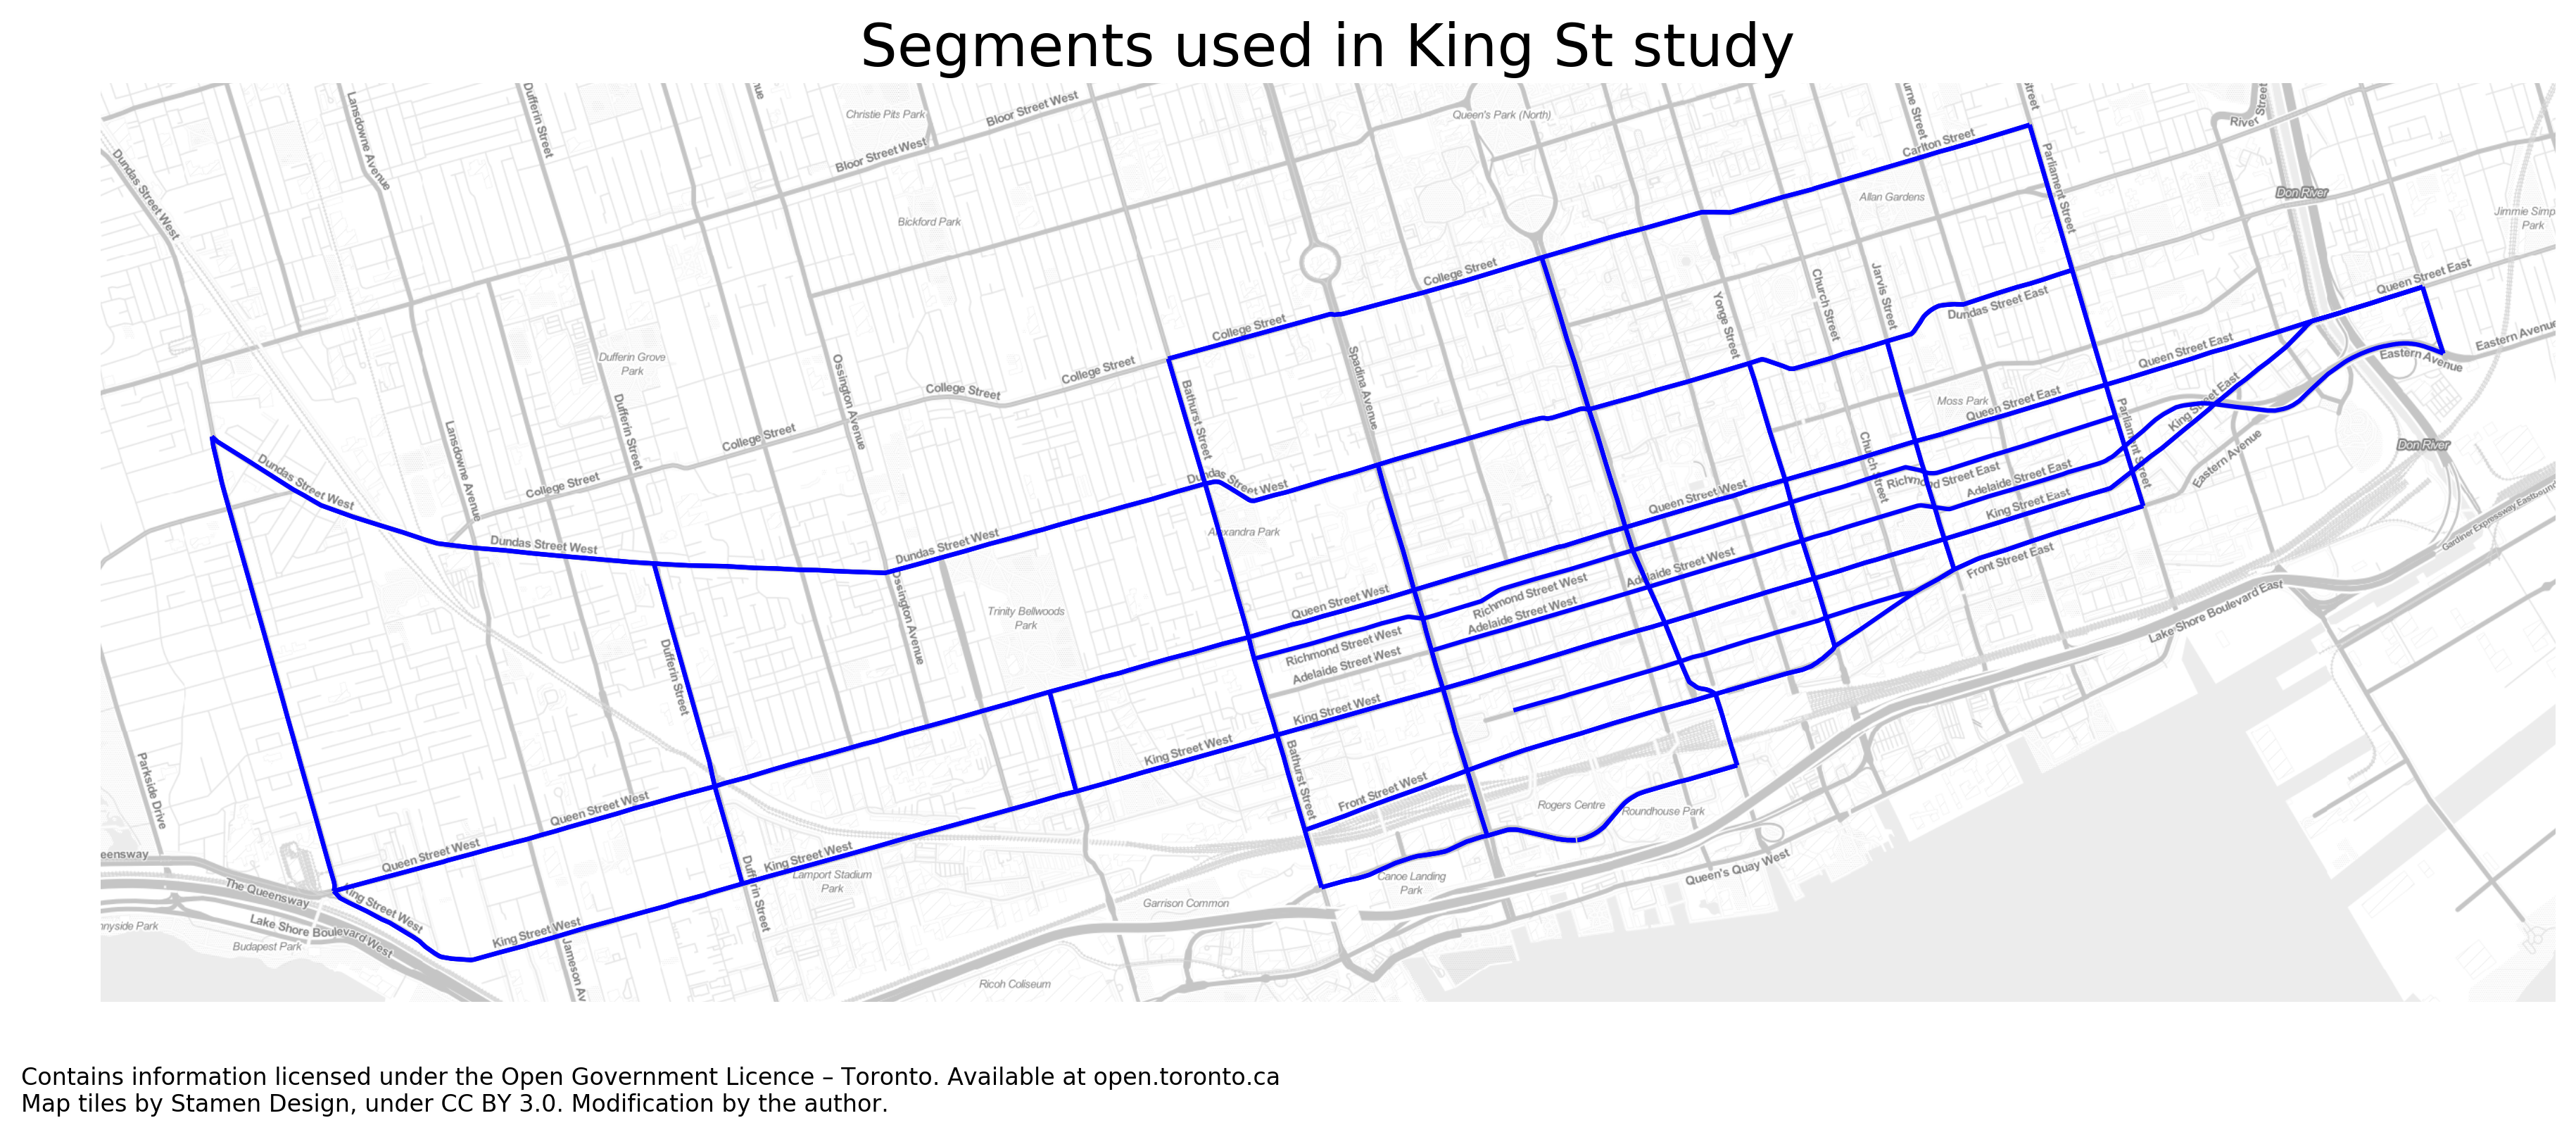

In [6]:
# map the segments to see what we're looking at

%matplotlib inline

fig=P.figure(figsize=(15,6),dpi=300)
ax=fig.add_subplot(111)

gdf.to_crs(epsg=3857).plot(ax=ax, edgecolor='b')

add_basemap(ax, zoom=15)

ax.set_axis_off()
ax.set_title('Segments used in King St study',fontsize = 20)
add_attribution_string(fig)
#P.savefig(output_path+'routes.png',bbox_inches='tight')

In [7]:
# now we begin the calculations

df_joined = df.join(gdf['length'])
df_joined['speed'] = (df_joined['length']/1000.)/(df_joined['tt']/3600.) #calculate speed in km/h instead of m/s
df_joined.astype({'speed':np.float64})
df_joined[:10]

datetime_bin    tt  obs  length      speed
segment_id                                                   
AD_JA_AD_PA 2018-01-01 00:00:00  62.0    1   734.0  42.619355
AD_JA_AD_PA 2018-01-01 00:10:00  65.0    2   734.0  40.652308
AD_JA_AD_PA 2018-01-01 00:15:00  73.0    1   734.0  36.197260
AD_JA_AD_PA 2018-01-01 00:20:00  90.5    2   734.0  29.197790
AD_JA_AD_PA 2018-01-01 00:25:00  76.0    1   734.0  34.768421
AD_JA_AD_PA 2018-01-01 00:30:00  61.5    2   734.0  42.965854
AD_JA_AD_PA 2018-01-01 00:35:00  72.0    1   734.0  36.700000
AD_JA_AD_PA 2018-01-01 00:40:00  73.0    3   734.0  36.197260
AD_JA_AD_PA 2018-01-01 00:45:00  81.0    3   734.0  32.622222
AD_JA_AD_PA 2018-01-01 00:50:00  69.5    6   734.0  38.020144

In [8]:
#calculate free-flow speed (FFS)

df_overnight = df_joined.reset_index().set_index('datetime_bin').between_time('21:00','06:00')
df_ffs = pd.pivot_table(df_overnight,
                       index='segment_id',
                       values='speed',
                       aggfunc=np.nanmean,
                       ).rename(columns={'speed':'FFS',})
df_ffs[:10]

FFS
segment_id            
AD_JA_AD_PA  40.817422
AD_PA_EA_BV  56.237843
AD_SP_AD_UN  20.895779
AD_UN_AD_YO  24.815283
AD_YO_AD_JA  28.137672
CO_BA_CO_UN  22.102242
CO_BA_DU_BA  29.061303
CO_PA_CO_UN  21.035326
CO_PA_DU_PA  26.376201
CO_UN_CO_BA  23.992653

In [9]:
#finally, calculate TTI

df_joined = df_joined.join(df_ffs)
df_joined['TTI']=df_joined['FFS']/df_joined['speed']
df_joined[:10]

datetime_bin    tt  obs  length      speed        FFS  \
segment_id                                                                 
AD_JA_AD_PA 2018-01-01 00:00:00  62.0    1   734.0  42.619355  40.817422   
AD_JA_AD_PA 2018-01-01 00:10:00  65.0    2   734.0  40.652308  40.817422   
AD_JA_AD_PA 2018-01-01 00:15:00  73.0    1   734.0  36.197260  40.817422   
AD_JA_AD_PA 2018-01-01 00:20:00  90.5    2   734.0  29.197790  40.817422   
AD_JA_AD_PA 2018-01-01 00:25:00  76.0    1   734.0  34.768421  40.817422   
AD_JA_AD_PA 2018-01-01 00:30:00  61.5    2   734.0  42.965854  40.817422   
AD_JA_AD_PA 2018-01-01 00:35:00  72.0    1   734.0  36.700000  40.817422   
AD_JA_AD_PA 2018-01-01 00:40:00  73.0    3   734.0  36.197260  40.817422   
AD_JA_AD_PA 2018-01-01 00:45:00  81.0    3   734.0  32.622222  40.817422   
AD_JA_AD_PA 2018-01-01 00:50:00  69.5    6   734.0  38.020144  40.817422   

                  TTI  
segment_id             
AD_JA_AD_PA  0.957720  
AD_JA_AD_PA  1.004062  
AD_JA_AD_PA  1.127638  
AD_JA_AD_PA  1.397963  
AD_JA_AD_PA  1.173980  
AD_JA_AD_PA  0.949997  
AD_JA_AD_PA  1.112191  
AD_JA_AD_PA  1.127638  
AD_JA_AD_PA  1.251215  
AD_JA_AD_PA  1.073574

TTI   obs  count_rank
hour segment_id                             
0    AD_JA_AD_PA  1.045429  3902           2
     AD_PA_EA_BV  1.069472   243           1
     AD_SP_AD_UN  1.443824  3278           2
     AD_UN_AD_YO  1.207647  5651           2
     AD_YO_AD_JA  1.085104  5970           2
     CO_BA_CO_UN  1.084723  1538           1
     CO_BA_DU_BA  1.232146  2805           1
     CO_PA_CO_UN  1.030817   263           1
     CO_PA_DU_PA  1.120306   783           1
     CO_UN_CO_BA  1.084335  1392           1

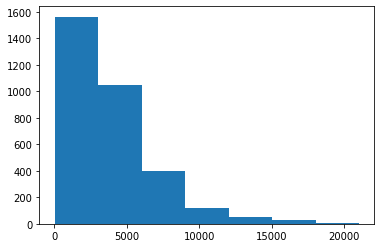

In [10]:
# this function converts number of counts (column called 'obs')
# to an ordinal number to determine the linewidth for the map
# the result is an apparent fattening of the line when there's more traffic
def count_rank(df,N=7):
    hist_y,hist_bins,hist = P.hist(df['obs'],bins=N)
    #hist_y,hist_bins = np.histogram(df['obs'],bins=N)
    # the second line is if you don't want to see the resulting histogram.
    # I always like to see it though, sanity checks ftw
    running_rank = N
    for i in range(0,N):
        running_rank -= (df['obs'] < hist_bins[i]).astype(int)
    return running_rank,hist_bins


# this function collapses all the data from the speed data table,
# to an average TTI and total number of observations, per hour
# so we're calculating the average 3am TTI and total 3am observations, and 4am, and 5am, ...
# the idea of writing the function this way is to allow further customization,
# such as if you want to view every half-hour, or specific times of day (such as AM and PM peak periods)
# that is left as an exercise to the reader
def groupby_hour(df):
    df = df.reset_index().set_index('datetime_bin')
    by_hour=[]
    hours = range(0,24)
    for hour in hours:
        sliced = df.between_time('%02d:00'%(hour),'%02d:00'%((hour+1)%24))
        df_hour = pd.pivot_table(sliced,
                                 index='segment_id',
                                 values=['TTI','obs'],
                                 aggfunc={'TTI':np.nanmean,
                                          'obs':np.sum}
                                )
        by_hour.append(df_hour)
    return pd.concat(by_hour,keys=hours,names=['hour','segment_id'])

# call the functions
N_ranks=7
avg_TTI_hour = groupby_hour(df_joined)
avg_TTI_hour['count_rank'],hist_bins = count_rank(avg_TTI_hour,N=N_ranks)

avg_TTI_hour[:10]

In [11]:
# save the results to file, so we don't have to run the code again every time

outfile_name = 'king_st_calculated_data.csv'
avg_TTI_hour.to_csv(data_path+outfile_name)

print('Written %d lines to file'%(len(avg_TTI_hour),outfile_name))
avg_TTI_hour[:10]

Written 3216 lines to file: /Users/jeffsalvail/documents/data/king_st_calculated_data.csv


TTI   obs  count_rank
hour segment_id                             
0    AD_JA_AD_PA  1.045429  3902           2
     AD_PA_EA_BV  1.069472   243           1
     AD_SP_AD_UN  1.443824  3278           2
     AD_UN_AD_YO  1.207647  5651           2
     AD_YO_AD_JA  1.085104  5970           2
     CO_BA_CO_UN  1.084723  1538           1
     CO_BA_DU_BA  1.232146  2805           1
     CO_PA_CO_UN  1.030817   263           1
     CO_PA_DU_PA  1.120306   783           1
     CO_UN_CO_BA  1.084335  1392           1

In [12]:
# pick up from here to load the crunched numbers for plotting

df = pd.read_csv(data_path+'king_st_calculated_data.csv').set_index(['hour','segment_id'])
print("Number of rows read:",len(df))
df[:10]

Number of rows read: 3216


TTI   obs  count_rank
hour segment_id                             
0    AD_JA_AD_PA  1.045429  3902           2
     AD_PA_EA_BV  1.069472   243           1
     AD_SP_AD_UN  1.443824  3278           2
     AD_UN_AD_YO  1.207647  5651           2
     AD_YO_AD_JA  1.085104  5970           2
     CO_BA_CO_UN  1.084723  1538           1
     CO_BA_DU_BA  1.232146  2805           1
     CO_PA_CO_UN  1.030817   263           1
     CO_PA_DU_PA  1.120306   783           1
     CO_UN_CO_BA  1.084335  1392           1

In [13]:
# now we join the speed data to the map, using the segment_id as the index
# geopandas always requires you to explicitly initiate the crs (coordinate refrence system) of the gdf

crs = {'init': 'epsg:4326'}
gdf_avg_TTI = gpd.GeoDataFrame(df.copy().join(gdf['geometry']), crs=crs)
gdf_avg_TTI[:10]

TTI   obs  count_rank  \
hour segment_id                                
0    AD_JA_AD_PA  1.045429  3902           2   
     AD_PA_EA_BV  1.069472   243           1   
     AD_SP_AD_UN  1.443824  3278           2   
     AD_UN_AD_YO  1.207647  5651           2   
     AD_YO_AD_JA  1.085104  5970           2   
     CO_BA_CO_UN  1.084723  1538           1   
     CO_BA_DU_BA  1.232146  2805           1   
     CO_PA_CO_UN  1.030817   263           1   
     CO_PA_DU_PA  1.120306   783           1   
     CO_UN_CO_BA  1.084335  1392           1   

                                                           geometry  
hour segment_id                                                      
0    AD_JA_AD_PA  LINESTRING (-79.37236535700001 43.651527616, -...  
     AD_PA_EA_BV  LINESTRING (-79.363598619 43.653564017, -79.36...  
     AD_SP_AD_UN  LINESTRING (-79.39557079399999 43.646740586, -...  
     AD_UN_AD_YO  LINESTRING (-79.385556196 43.648869021, -79.38...  
     AD_YO_AD_JA  LINESTRING (-79.378470071 43.650407486, -79.37...  
     CO_BA_CO_UN  LINESTRING (-79.407722935 43.656481958, -79.40...  
     CO_BA_DU_BA  LINESTRING (-79.407722935 43.656481958, -79.40...  
     CO_PA_CO_UN  LINESTRING (-79.367981848 43.664285907, -79.36...  
     CO_PA_DU_PA  LINESTRING (-79.367981848 43.664285907, -79.36...  
     CO_UN_CO_BA  LINESTRING (-79.39049459899999 43.659858837, -...

<IPython.core.display.Javascript object>


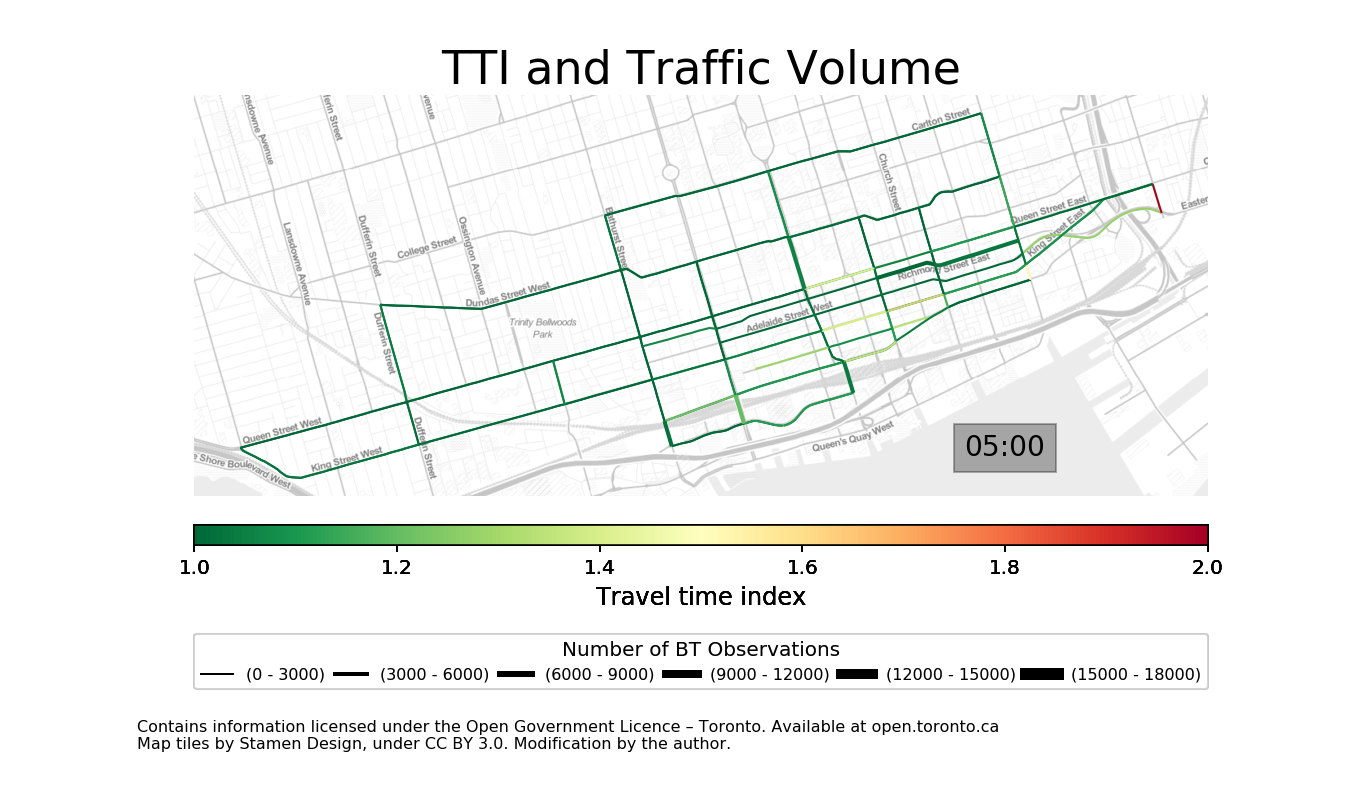

In [15]:
%matplotlib notebook

# this cell needs to be run twice to work :(
# something to do with the blitting
#

fig=P.figure(figsize=(9.5,5.5))
fig.suptitle(attribution_string,
              x=0.1,y=0.05,
              ha = 'left',
              va = 'bottom',
              fontsize=8,
            )
ax=fig.add_subplot(111)
ax.set_axis_off()

def init():
    ax.clear()
    ax.set_title('TTI and Traffic Volume',fontsize=23)
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("bottom", size="5%", pad=0.2)
    num=256.
    TTI_min,TTI_max = 1.0,2.0
    X = np.linspace(TTI_min,TTI_max,num=num)
    gradient = [X for i in range(0,5)]
    cax.pcolor(X,list(range(0,5)),gradient,cmap='RdYlGn_r')
    cax.set_yticks([])
    cax.set_xlabel('Travel time index',fontsize=12)
    
    lax = divider.append_axes("bottom", size="1%", pad=1.0)
    linewidth_handles = []
    for linewidth in range(1,N_ranks+1):
        line = Line2D([0], [0], color='k', lw=linewidth),
        linewidth_handles.append(line)
    lax.legend(linewidth_handles, ['(%d - %d)'%(1000*int(hist_bins[i]/1000),1000*int(hist_bins[i+1]/1000)) for i in range(0,N_ranks-1)],
               fontsize=8,
               title='Number of BT Observations', 
               bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=N_ranks)
               #bbox_to_anchor=(1.05,0), loc="lower left", borderaxespad=0)
    
    lax.set_axis_off()
    
    gdf.to_crs(epsg=3857).plot(ax=ax,edgecolor='k')
    add_basemap(ax, zoom=14,url=ctx.sources.ST_TONER_LITE,alpha=0.5)
    ax.set_axis_off()

def animate(epoch):
    ax.clear()
    ax.set_title('TTI and Traffic Volume',fontsize=23)
    gdf_avg_TTI_epoch = gdf_avg_TTI.loc[epoch,:].copy()
    
    for rank,df_rank in gdf_avg_TTI_epoch.groupby(by='count_rank'):
        df_rank.to_crs(epsg=3857).plot(ax=ax,
                                       linewidth=rank,
                                       column='TTI',
                                       vmin=1.0,
                                       vmax=2.0,
                                       cmap='RdYlGn_r',
                                       legend=False,
                                           )
        
    add_basemap(ax, zoom=14,url=ctx.sources.ST_TONER_LITE,alpha=0.5)
    ax.text(0.76, 0.1,
            '%02d:00'%(epoch),
            fontsize=14,
            bbox={'facecolor':'black', 'alpha':0.3, 'pad':5},
            transform=ax.transAxes,
           )
    ax.set_axis_off()
    


epochs=np.arange(0,24)
ani = matplotlib.animation.FuncAnimation(fig,
                                         animate,
                                         epochs,
                                         init_func=init,
                                         blit=False
                                        )
P.show()

/Users/jeffsalvail/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


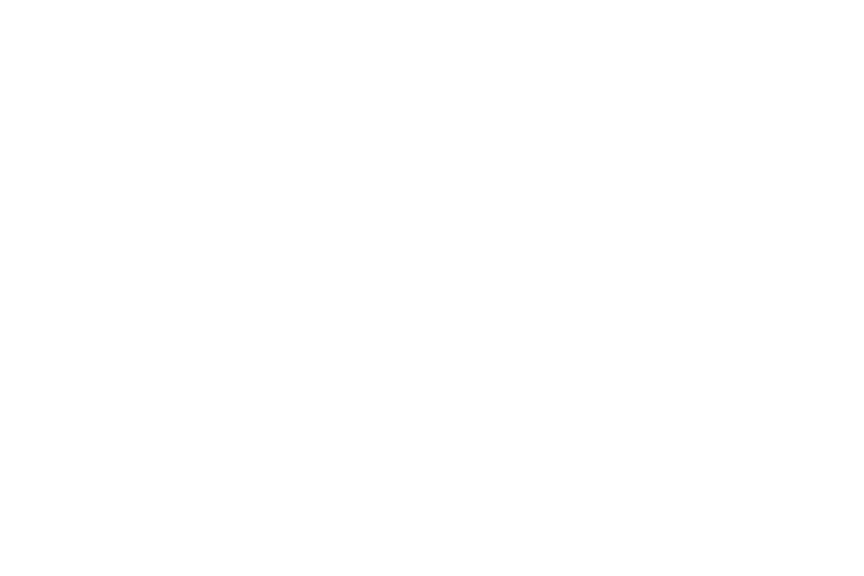

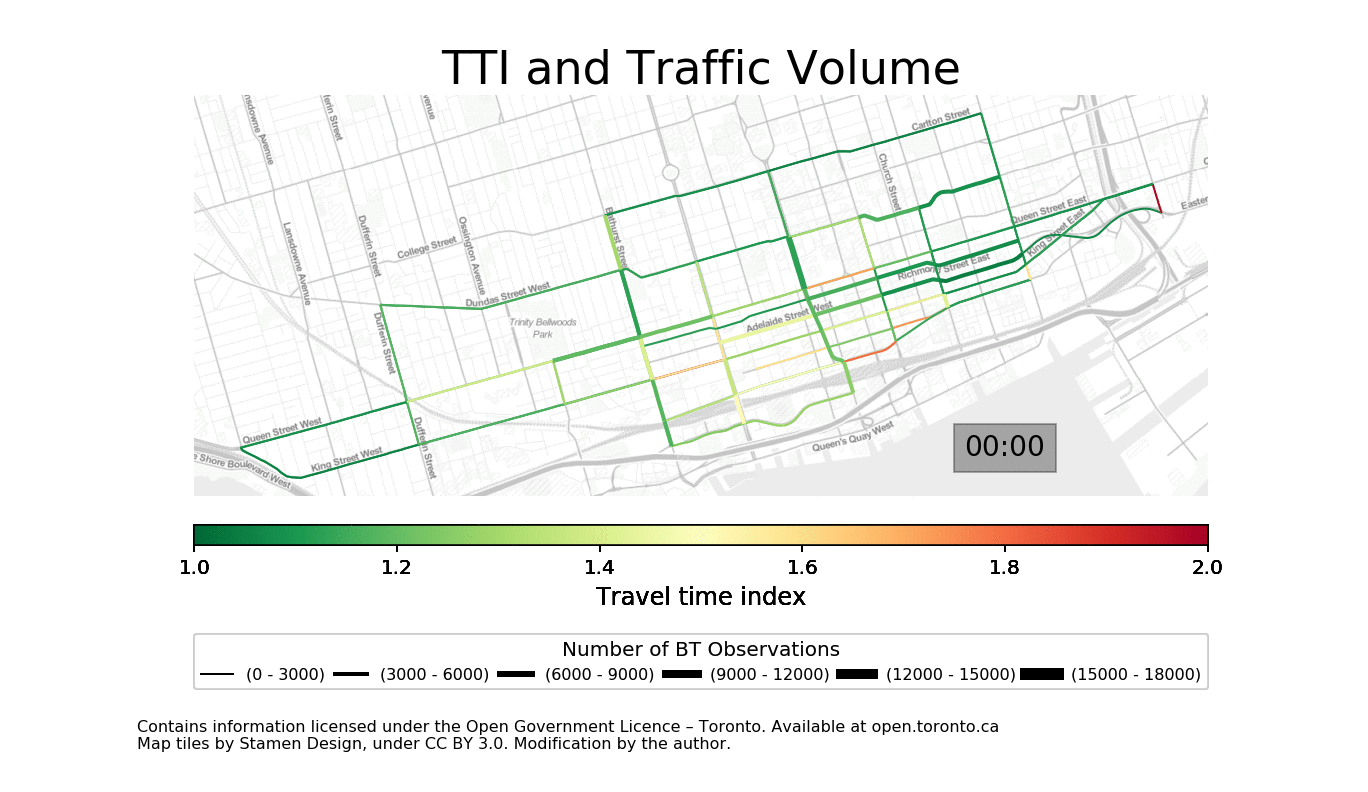

In [16]:
# save the animation to a gif, and load it and display to make sure it works.

#http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/
from IPython.display import HTML, Image
ani.save(output_path+'king_st_TTI_counts.gif', writer='imagemagick', fps=1)
Image(filename=output_path+'king_st_TTI_counts.gif')

# Fin